In [1]:
# Notebook to put together plots and animations showing ocean model configuration
# Specifically to understand how the ocean state develops over time, how particualr metrics behave,
# and how the dynamics evolved as the model moves to equilibrium 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from  matplotlib.animation import FFMpegWriter
import os
#import ffmpeg

from netCDF4 import Dataset
from matplotlib.cm import get_cmap
#from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
#                 cartopy_ylim, latlon_coords)

In [3]:
# Read in the model data, both state files, and time averaged files

dir = '/data/hpcdata/users/racfur/MITGCM_OUTPUT/20000yr_Windx1.00_mm_diag/'

#Running with files from first 10,000 years
mm_file   = dir + 'cat_tave_selectvars.nc'

ds_mm=xr.open_dataset(mm_file)

nc_mm = Dataset(mm_file)

# Get the variable fields
var = ['Temp', 'Ttave']
#var = ['S', 'Stave']
#var = ['U', 'uVeltave']
#var = ['V', 'vVeltave']

mm_var = nc_mm.variables[var[1]][:]

#close the files
nc_mm.close()

start = [1, 'start']
mid = [60000, 'middle'] #[round(ds_mm.T.size/2), 'middle']  # 1667 years
end = [120000, 'end'] #[ds_mm.T.size - 1, 'end']  # 3333 years

In [38]:
print(mm_var.shape)
ds_mm

(120001, 42, 78, 11)


<xarray.Dataset>
Dimensions:   (T: 120001, X: 11, Xp1: 12, Y: 78, Z: 42)
Coordinates:
  * T         (T) float64 2.592e+06 5.184e+06 7.776e+06 ... 3.11e+11 3.11e+11
  * X         (X) float64 1.0 3.0 5.0 7.0 9.0 11.0 13.0 15.0 17.0 19.0 21.0
  * Xp1       (Xp1) float64 0.0 2.0 4.0 6.0 8.0 ... 14.0 16.0 18.0 20.0 22.0
  * Y         (Y) float64 -59.5 -58.48 -57.44 -56.36 ... 58.48 59.5 60.5 61.5
  * Z         (Z) float64 -5.0 -15.05 -25.25 ... -4.625e+03 -4.875e+03
Data variables:
    Ttave     (T, Z, Y, X) float32 ...
    uVeltave  (T, Z, Y, Xp1) float32 ...
Attributes:
    the_run_name:              2deg
    MITgcm_version:            checkpoint67g
    build_user:                rfurner
    build_host:                jasmin-sci1.ceda.ac.uk
    build_date:                Mon Feb 18 16:24:31 GMT 2019
    MITgcm_URL:                http://mitgcm.org
    MITgcm_tag_id:             
    MITgcm_mnc_ver:            0.9
    tile_number:               1
    bi:                        1
    bj:   

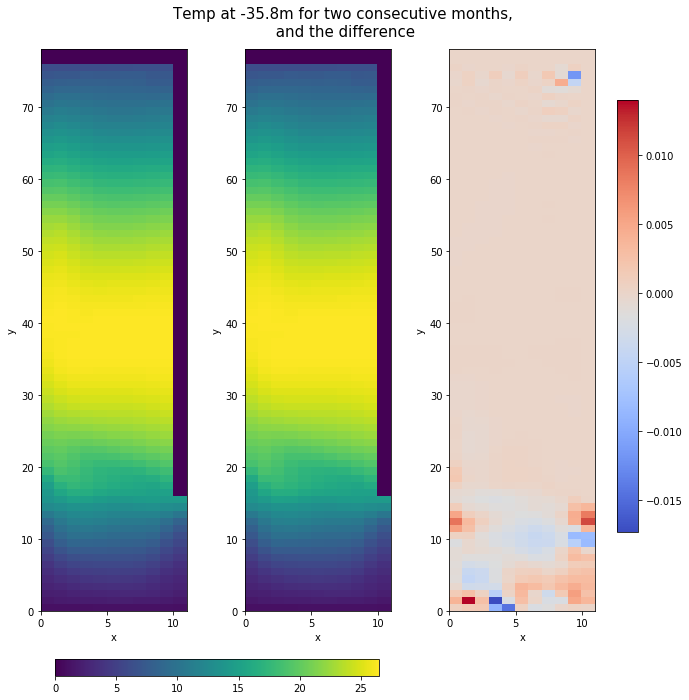

In [6]:
#Do a quick plot of temp just below surface, and again one month later, and diff

fig = plt.figure(figsize=(10,10))
ax1=plt.subplot(131)
plt.pcolormesh(mm_var[2000,3,:,:])
plt.xlabel('x')
plt.ylabel('y')
ax2=plt.subplot(132)
plt.pcolormesh(mm_var[2001,3,:,:])
plt.xlabel('x')
plt.ylabel('y')
cbaxes = fig.add_axes([0.1, 0.03, 0.45, 0.024]) 
#cb = plt.colorbar(im, cax = cbaxes) 
cb=plt.colorbar(ax=(ax1,ax2), cax = cbaxes, orientation='horizontal')

ax3=plt.subplot(133)
im = plt.pcolormesh(mm_var[2000,3,:,:]-mm_var[2001,3,:,:], cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('y')

plt.subplots_adjust(wspace=0.4, top=0.9, bottom=0.12, left=0.08, right=0.85)
plt.suptitle(var[0]+' at '+str(ds_mm.Z[3].data)+'m for two consecutive months,\n and the difference', fontsize=15, x=0.5, y=0.96,)
cbaxes = fig.add_axes([0.88, 0.23, 0.03, 0.6]) 
cb = plt.colorbar(im, cax = cbaxes) 

plt.show()
fig.savefig('../model_plots_anims/forpp_'+var[0]+'_nearsurface.png')
plt.close()



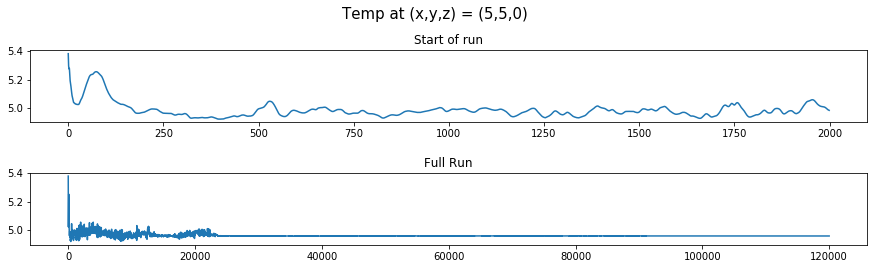

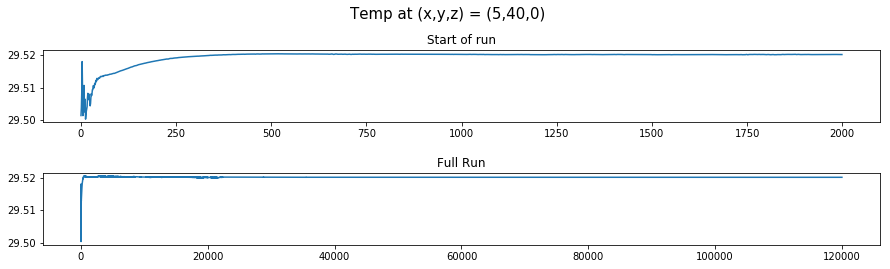

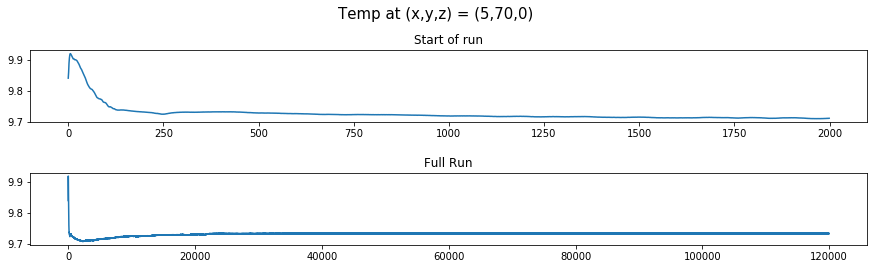

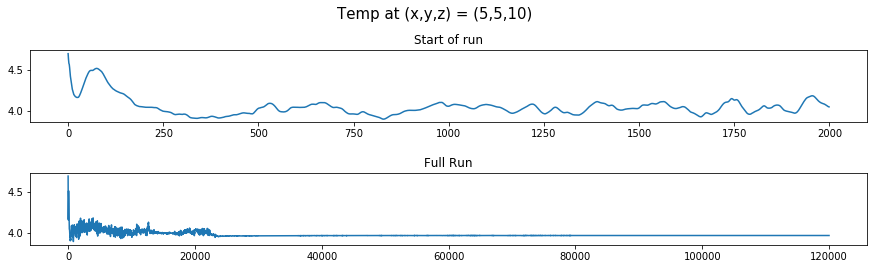

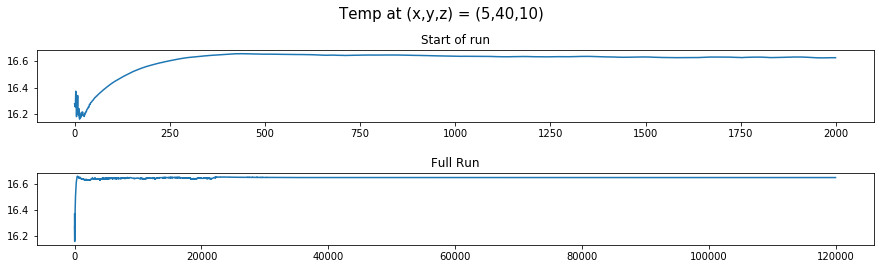

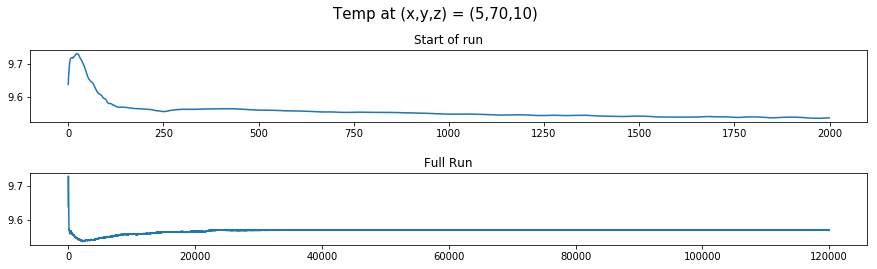

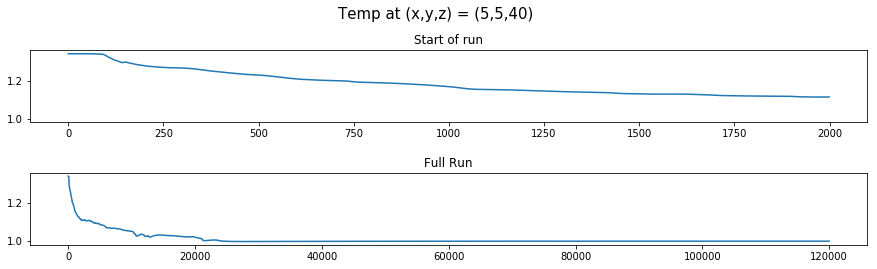

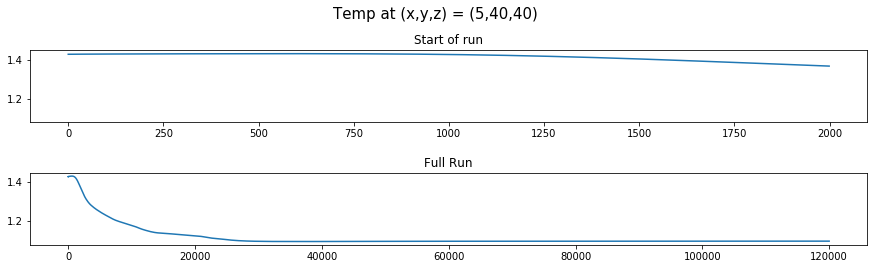

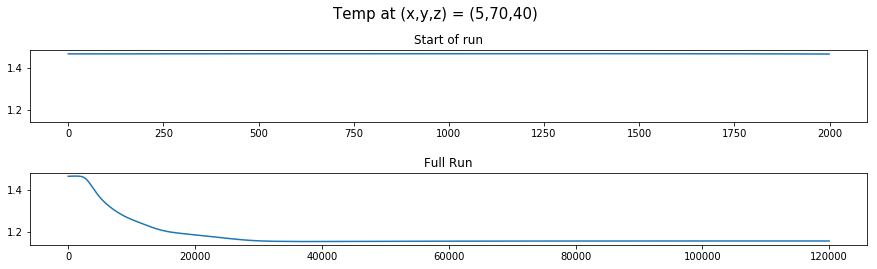

In [7]:
# Plot time series at a few specific points, with monthly mean and instantaneous on same plot

points=[[5,5,0], [5,40,0], [5,70,0], [5,5,10], [5,40,10], [5,70,10], [5,5,40], [5,40,40], [5,70,40]]   # list of x,y,z points

for point in points:
    fig = plt.figure(figsize=(15,4))
    
    ax2 = fig.add_subplot(212)
    ax2.plot(mm_var[:end[0],point[2],point[1],point[0]])
    ax2.set_title('Full Run')
    ylim = np.array(plt.ylim())
    
    ax1 = fig.add_subplot(211)
    ax1.plot(mm_var[:2000,point[2],point[1],point[0]])
    ax1.set_title('Start of run')
    plt.ylim(ylim)
      
     
    plt.suptitle(var[0]+' at (x,y,z) = ('+str(point[0])+','+str(point[1])+','+str(point[2])+')', x=0.5, y=0.95, fontsize=15)
    plt.subplots_adjust(hspace=0.7, top=0.8)
    
    plt.show()
    fig.savefig('../model_plots_anims/forpp_'+var[0]+'_x'+str(point[0])+'_y'+str(point[1])+'_z'+str(point[2])+'.png')
    plt.close()

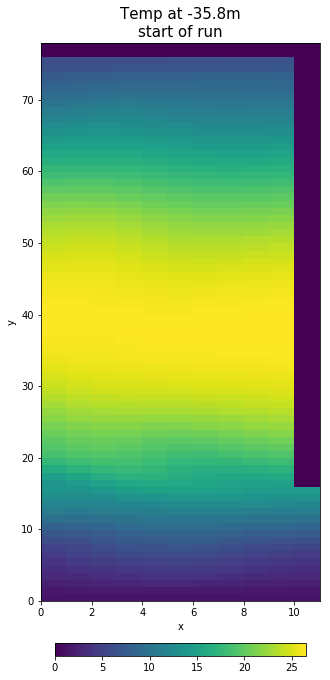

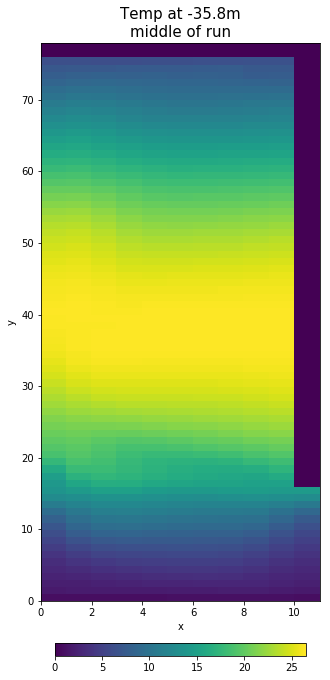

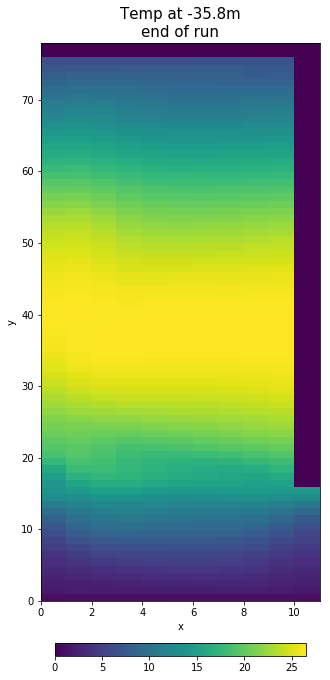

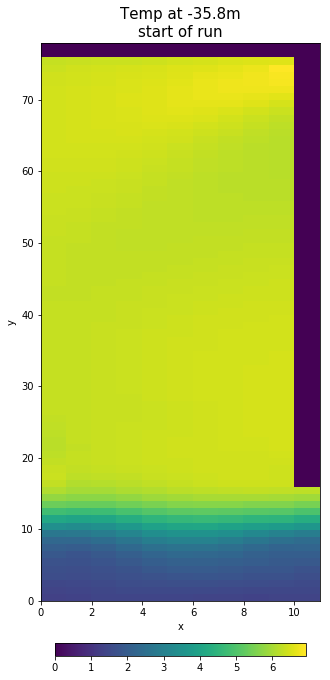

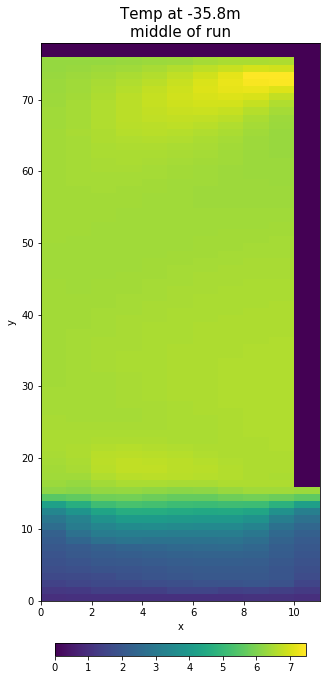

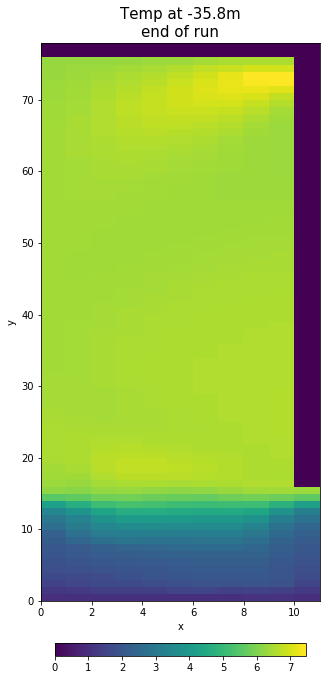

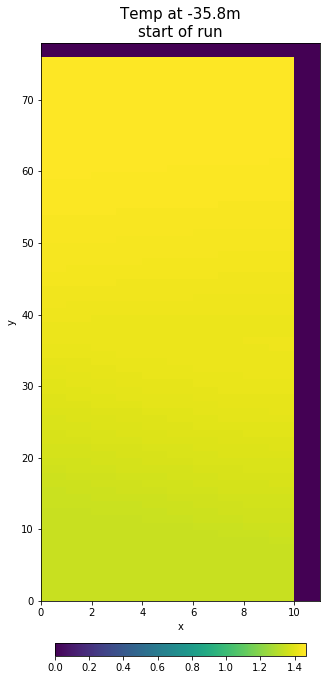

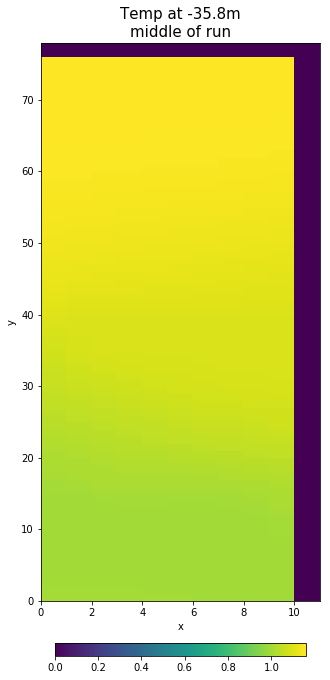

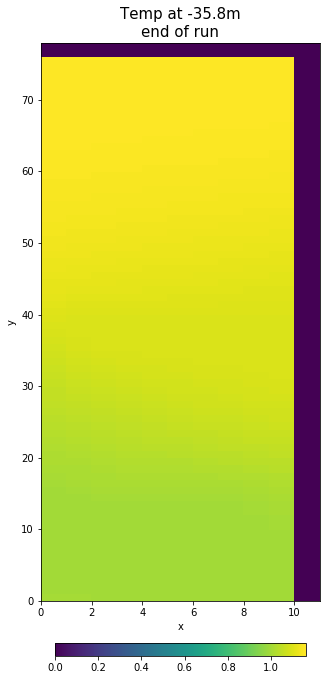

In [41]:
# Plot fields at a few discrete times - start, middle and end, 
# for the near surface, a mid-depth, and near the bottom

for depth in [3,20,40]:
    for time in [start, mid, end]:

        min_value = np.amin(mm_var[time[0],depth,:,:])  # Lowest value
        if var[0] == 'S':
            min_value = 33.5
        max_value = np.amax(mm_var[time[0],depth,:,:])  # Highest value
        
        # Create a figures
        fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(5,13))
        im1 = ax1.pcolormesh(mm_var[time[0],depth,:,:], vmin=min_value, vmax=max_value)
        ax1.set_title(var[0]+' at '+str(ds_mm.Z[3].data)+'m\n'+time[1]+' of run', x=0.5, y=1., fontsize=15)
    
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')

        # Add a color bar
        #cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.1, pad=0.1)
        cb=plt.colorbar(im1, ax=(ax1),  orientation='horizontal', pad=0.06, shrink=0.9)
        
        plt.show()
        fig.savefig('../model_plots_anims/'+var[0]+'_'+time[1]+'_z'+str(depth)+'.png')
        plt.close()


In [ ]:
# # Make animation of surface field over time for monthly mean file, and instantaneous output file
# # Following method from http://tech.weatherforce.org/blog/ecmwf-data-animation/index.html, 
# # see also https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# plt.rcParams['animation.ffmpeg_path'] = '/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/bin/ffmpeg'

# for depth in [3,20,40]:

#     fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(5,7))

#     frames = end[0] #inst_var[:,0,0,0].shape[0]      # Number of frames
#     min_value = min(np.amin(inst_var[:,depth,:,:]), np.amin(mm_var[:,depth,:,:]))  # Lowest value
#     if var[0] == 'S':
#         min_value = 33.5
#     max_value = max(np.amax(inst_var[:,depth,:,:]), np.amax(mm_var[:,depth,:,:]))   # Highest value
#     print(min_value, max_value)

#     def draw(frame, add_colorbar):
#         ax1=axes[0]
#         ax2=axes[1]
#         im1 = ax1.pcolormesh(inst_var[frame,depth,:,:], vmin=min_value, vmax=max_value)
#         ax1.set_title('instant.')
#         im2 = ax2.pcolormesh(mm_var[frame,depth,:,:], vmin=min_value, vmax=max_value) 
#         ax2.set_title('monthly\nmean')

#         plt.subplots_adjust(wspace=.6, top=0.85, bottom=0.0)
#         ax1.set_xlabel('\'longitude\'')
#         ax2.set_xlabel('\'longitude\'')
#         ax1.set_ylabel('\'latitude\'')
#         plt.suptitle(var[0]+' at z='+str(depth)+'\ntime = '+str(frame), x=0.5, y=0.98, fontsize=15)            

#         ## Add a color bar
#         if add_colorbar:
#             cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.1, anchor=(0.5, 1.))

#         plt.close()    
#         return im1
       
#     def init():
#         return draw(0, add_colorbar=True)

#     def animate(frame):
#         return draw(frame, add_colorbar=False)

#     ani = animation.FuncAnimation(fig, animate, frames, interval=5, blit=False,
#                                   init_func=init, repeat=False)
#     ani.save('../model_plots_anims/'+var[0]+'_z'+str(depth)+'.mp4', writer=animation.FFMpegWriter(fps=8))
#     plt.show()
#     plt.close(fig)

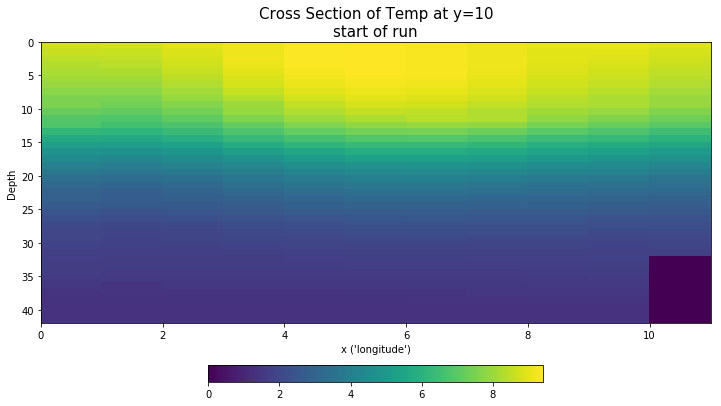

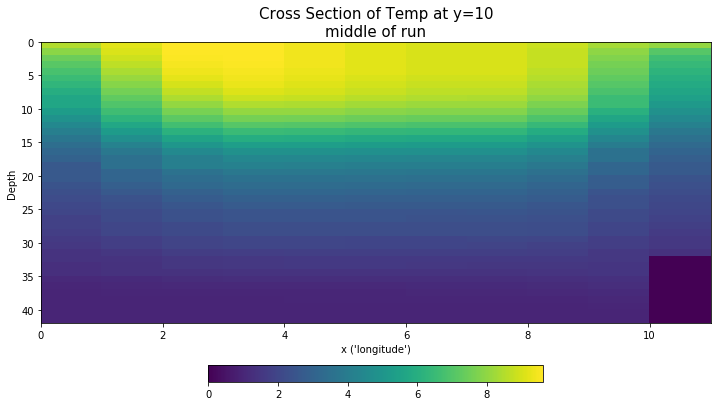

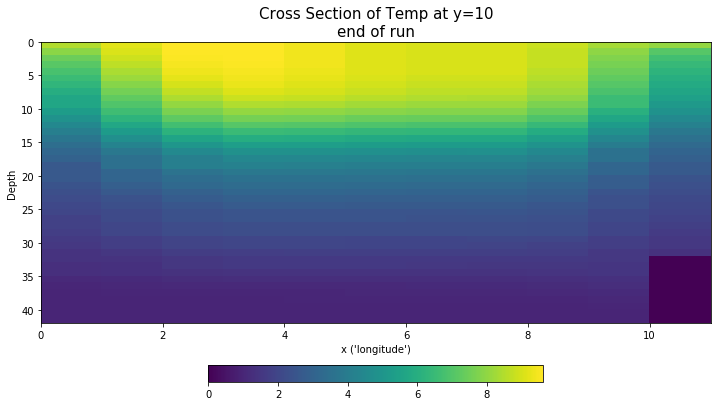

In [57]:
# Plot cross sections for y=const at a few discrete time points - start, middle and end, 

# start, middle and end points defined above
y=10

# Plot cross section at y=const (i.e. east to west)
for time in [start, mid, end]:
    
    min_value = np.amin(mm_var[time[0],:,y,:])  # Lowest value
    if var[0] == 'S':
        min_value = 33.5
    max_value = np.amax(mm_var[time[0],:,y,:])  # Highest value
        
    # Create a figures of surface
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(12,7))
    ax1.invert_yaxis()
    im1 = ax1.pcolormesh(mm_var[time[0],:,y,:], vmin=min_value, vmax=max_value)
    ax1.set_title('Cross Section of '+var[0]+' at y='+str(y)+'\n'+time[1]+' of run', x=0.5, y=1., fontsize=15)

    #fig.text(0.5, 0.155, 'latitude', ha='center', va='center', fontsize=11)
    ax1.set_ylabel('Depth')
    ax1.set_xlabel('x (\'longitude\')')

    # Add a color bar
    cb=plt.colorbar(im1, ax=(ax1), orientation='horizontal', shrink=0.5, pad=0.11)

    plt.show()
    fig.savefig('../model_plots_anims/'+var[0]+'_CrossSection_y'+str(y)+'_'+time[1]+'.png')
    plt.close()


In [ ]:
# # Make animation of cross section  at y=const, in the Southern Ocean over time - Monthly means and instantaneous outputs
# # Following method from http://tech.weatherforce.org/blog/ecmwf-data-animation/index.html, 
# # see also https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# plt.rcParams['animation.ffmpeg_path'] = '/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/bin/ffmpeg'

# # Plot cross section at y=const (i.e. east to west)
# fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(8,10))
# axes[0].invert_yaxis()
# axes[1].invert_yaxis()

# frames = end[0] #  inst_var[:,0,0,0].shape[0]      # Number of frames
# min_value = min(np.amin(inst_var[:,:,y,:]), np.amin(mm_var[:,:,y,:]))  # Lowest value
# if var[0] == 'S':
#     min_value = 33.5
# max_value = max(np.amax(inst_var[:,:,y,:]), np.amax(mm_var[:,:,y,:]))  # Highest value

# def draw(frame, add_colorbar):
#     ax1=axes[0]
#     ax2=axes[1]    
#     im1 = ax1.pcolormesh(inst_var[frame,:,y,:], vmin=min_value, vmax=max_value)
#     ax1.set_title('Instantaneous')
#     im2 = ax2.pcolormesh(mm_var[frame,:,y,:], vmin=min_value, vmax=max_value) 
#     ax2.set_title('Monthly mean')##

#     ##plt.ylabel
#     ax1.set_ylabel('Depth')
#     ax2.set_ylabel('Depth')
#     ax1.set_xlabel('\'longitude\'')
#     ax2.set_xlabel('\'longitude\'')
#     plt.suptitle('Cross Section of '+var[0]+' at y='+str(y)+'\ntime = '+str(frame), x=0.5, y=0.98, fontsize=15)

#     plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.0)

#     # Add a color bar
#     if add_colorbar:
#         cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.0, anchor=(0.5, 1.5))

#     return im1
   
# def init():
#     return draw(0, add_colorbar=True)

# def animate(frame):
#     return draw(frame, add_colorbar=True)

# ani = animation.FuncAnimation(fig, animate, frames, interval=20, blit=False,
#                               init_func=init, repeat=False)
# ani.save('../model_plots_anims/'+var[0]+'_CrossSection_y'+str(y)+'.mp4', writer=animation.FFMpegWriter(fps=8))
# plt.show()
# plt.close(fig)


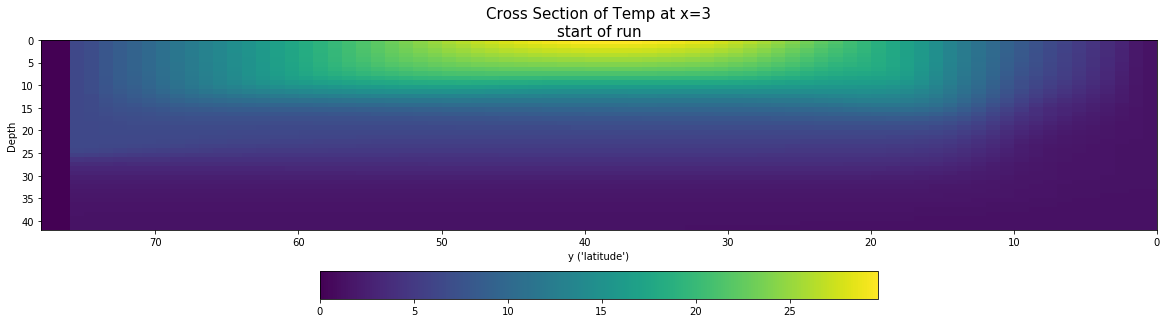

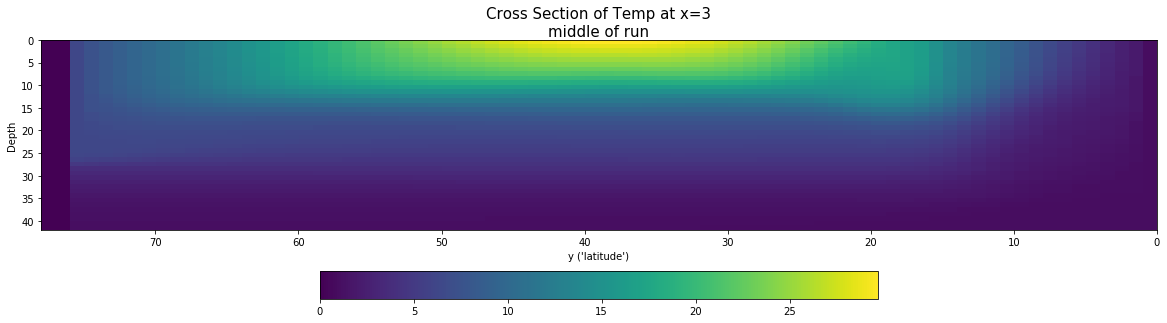

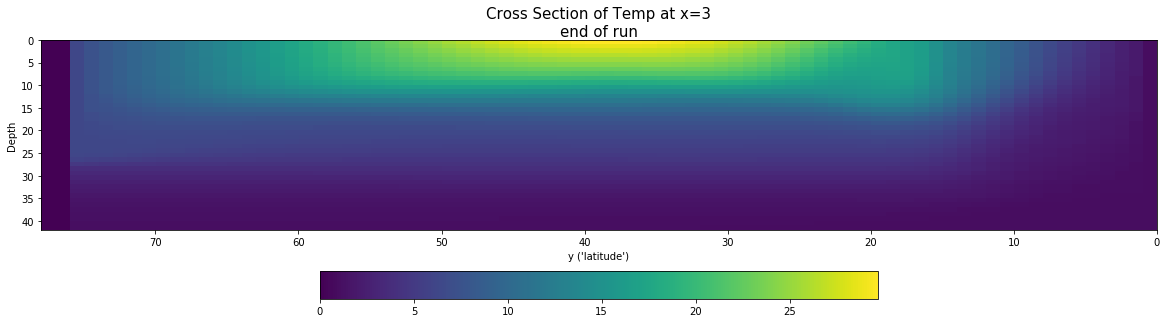

In [51]:
# Plot cross section at x=const (i.e. North to South)    

x=3

for time in [start, mid, end]:
    
    min_value = np.amin(mm_var[time[0],:,:,x])  # Lowest value
    if var[0] == 'S':
        min_value = 33.5
    max_value = np.amax(mm_var[time[0],:,:,x])   # Highest value
        
    # Create a figures of surface
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(20,5))
    ax1.invert_yaxis()
    ax1.invert_xaxis()
    im1 = ax1.pcolormesh(mm_var[time[0],:,:,x], vmin=min_value, vmax=max_value)
    ax1.set_title('Cross Section of '+var[0]+' at x='+str(x)+'\n'+time[1]+' of run', x=0.5, y=0.99, fontsize=15)

    ax1.set_ylabel('Depth')
    ax1.set_xlabel('y (\'latitude\')')

    # Add a color bar
    cb=plt.colorbar(im1, ax=(ax1), orientation='horizontal', shrink=0.5, pad=0.15)
        
    plt.show()
    fig.savefig('../model_plots_anims/'+var[0]+'_CrossSection_x'+str(x)+'_'+time[1]+'.png')
    plt.close() 

In [ ]:
# # Make animation of cross section  at x=const, over time - Monthly means and instantaneous outputs
# # Following method from http://tech.weatherforce.org/blog/ecmwf-data-animation/index.html, 
# # see also https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# plt.rcParams['animation.ffmpeg_path'] = '/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/bin/ffmpeg'

# # Plot cross section at y=const (i.e. east to west)
# fig, axes = plt.subplots(nrows=2, ncols=1, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(8,10))
# axes[0].invert_yaxis()
# axes[1].invert_yaxis()
# axes[0].invert_xaxis()
# axes[1].invert_xaxis()
    
# frames = end[0] #  inst_var[:,0,0,0].shape[0]      # Number of frames
# min_value = min(np.amin(inst_var[:,:,:,x]), np.amin(mm_var[:,:,:,x]))  # Lowest value
# if var[0] == 'S':
#     min_value = 33.5
# max_value = max(np.amax(inst_var[:,:,:,x]), np.amax(mm_var[:,:,:,x]))   # Highest value

# def draw(frame, add_colorbar):
#     ax1=axes[0]
#     ax2=axes[1]
#     im1 = ax1.pcolormesh(inst_var[frame,:,:,x], vmin=min_value, vmax=max_value)
#     ax1.set_title('Instantaneous')
#     im2 = ax2.pcolormesh(mm_var[frame,:,:,x], vmin=min_value, vmax=max_value) 
#     ax2.set_title('Monthly mean')##

#     ax1.set_ylabel('Depth')
#     ax2.set_ylabel('Depth')
#     ax1.set_xlabel('\'latitude\'')
#     ax2.set_xlabel('\'latitude\'')
#     plt.suptitle('Cross Section of '+var[0]+' at x='+str(x)+'\ntime = '+str(frame), x=0.5, y=0.97, fontsize=15)
#     plt.subplots_adjust(hspace=0.3, top=0.89, bottom=0.0)
    
#     # Add a color bar
#     if add_colorbar:
#         cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=0.75, anchor=(0.5, 1.5))

#     return im1
   
# def init():
#     return draw(0, add_colorbar=True)

# def animate(frame):
#     return draw(frame, add_colorbar=True)

# ani = animation.FuncAnimation(fig, animate, frames, interval=20, blit=False,
#                               init_func=init, repeat=False)
# ani.save('../model_plots_anims/'+var[0]+'_CrossSection_x'+str(x)+'.mp4', writer=animation.FFMpegWriter(fps=8))
# plt.show()
# plt.close(fig)

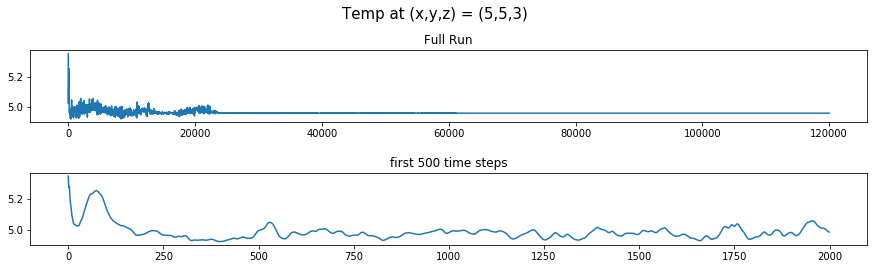

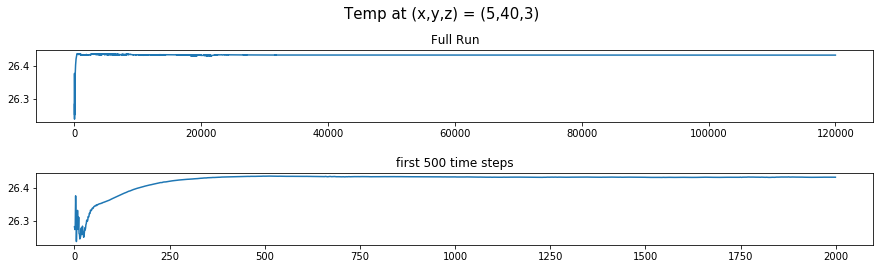

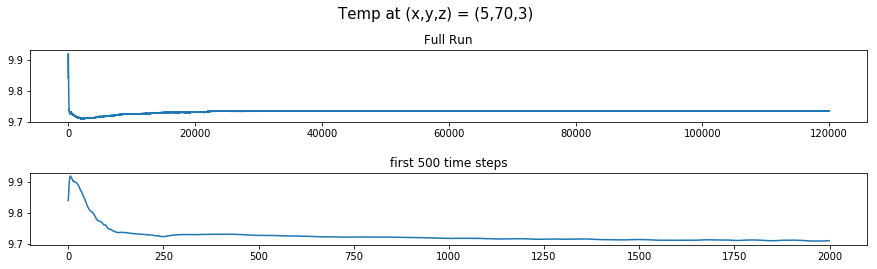

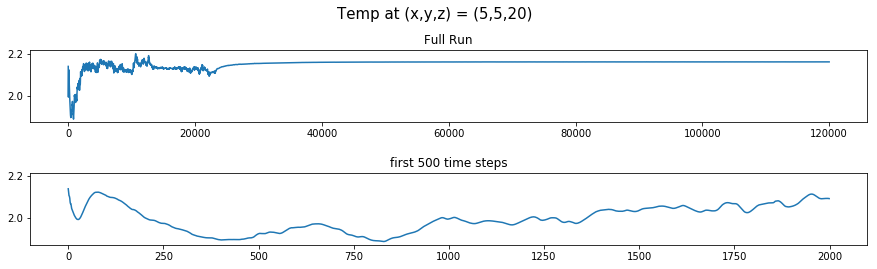

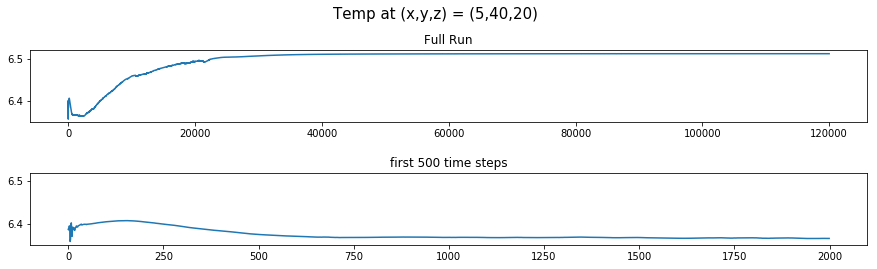

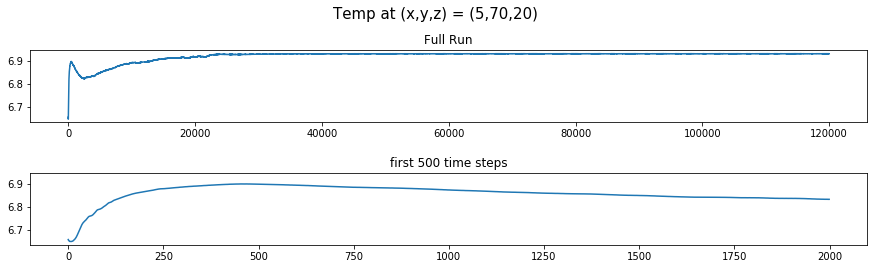

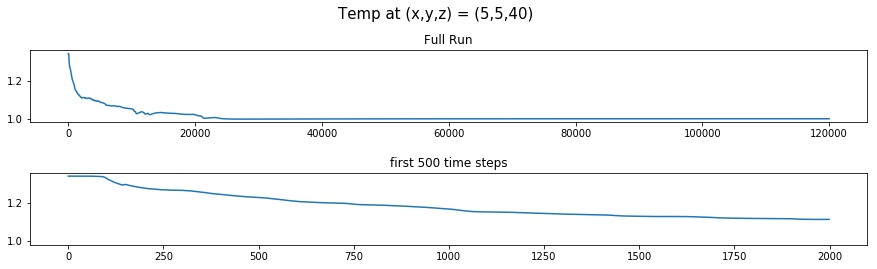

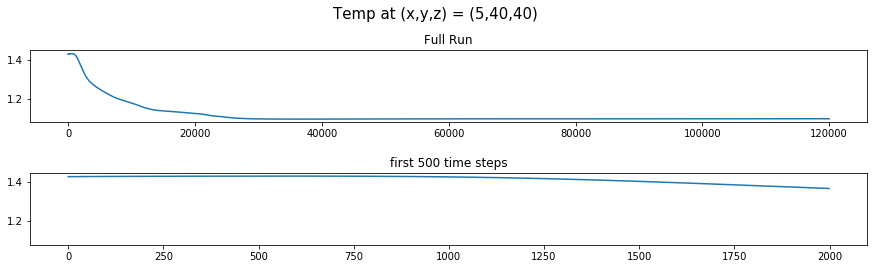

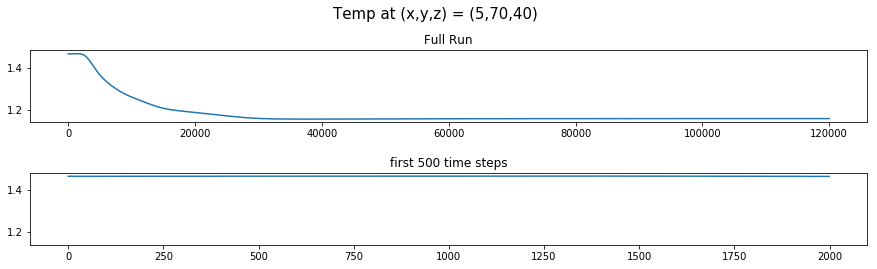

In [59]:
# Plot time series at a few specific points

points=[[5,5,3], [5,40,3], [5,70,3], [5,5,20], [5,40,20], [5,70,20], [5,5,40], [5,40,40], [5,70,40]]   # list of x,y,z points

for point in points:

    fig = plt.figure(figsize=(15,4))
    
    ax1 = fig.add_subplot(211)
    ax1.plot(mm_var[:end[0],point[2],point[1],point[0]])
    ax1.set_title('Full Run')
    ylim = np.array(plt.ylim())
    
    ax2 = fig.add_subplot(212)
    ax2.plot(mm_var[:2000,point[2],point[1],point[0]])
    ax2.set_title('first 500 time steps')
    plt.ylim(ylim)
    
    plt.suptitle(var[0]+' at (x,y,z) = ('+str(point[0])+','+str(point[1])+','+str(point[2])+')', x=0.5, y=0.95, fontsize=15)
    plt.subplots_adjust(hspace=0.7, top=0.8)
    
    plt.show()
    fig.savefig('../model_plots_anims/'+var[0]+'_x'+str(point[0])+'_y'+str(point[1])+'_z'+str(point[2])+'.png')
    plt.close()

In [ ]:
# Calculate some specific metrics (WHAT?!) and output these/plot time series of these metrics over time

nc_mon.variables['Theta_min']

fig = plt_figure()
fig.plot(nc_mon.variables['Theta_min'])
fig.set_title('Minimum Temperature')
